In [1]:
import random
import math
import numpy as np
import Parsing_midi as pm
import Init_chromo as init
import mido
from mido import Message, MidiFile, MidiTrack
from collections import Counter
import copy
import matplotlib.pyplot as plt
from itertools import combinations # product: 排列

In [2]:
"""
## import function

- Parsing_midi
    - get_midi
    - get_pitch
    - parse_midi
    - separate_phrase

- Init_chromo
    - shift_note
    - merge_duplicate_note
    - extend_duration
"""
print()

### Output to midi file

In [3]:
def to_midi_file(inputfile, program, outputfile):
    ## initialize
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    ## add message
    track.append(Message('program_change', program=program, time=0))
    for i in range(len(inputfile)):
        track.append(Message('note_on', note=inputfile[i].note, velocity=inputfile[i].velocity, time=inputfile[i].time))
    mid.save(outputfile)
    return True

### Seperate phrase
- one bar = 1920 (4 beats)
- sliding window = 7680 (4 bar)
- Parameters:
    - base
    - midi list
    - threshold

In [4]:
midi_list = pm.get_midi('MidiSample/sky.mid', 0)

In [5]:
def trans_note_list(song):
    return [song[i].note for i in range(len(song))]

note_msg, midi_msg = pm.separate_song(midi_list, 7680)
parent = midi_msg[0]  # change here for testing

def flatten_list(midi_list):
    return [item for sublist in midi_list for item in sublist]

In [6]:
## transform to C major #-3
for i in range(len(parent)):
    parent[i].note = parent[i].note -3 # shift
[parent[i].note - 9 for i in range(len(parent))]
    
to_midi_file(parent, 1 , 'test1.mid')

True

In [7]:
## original
note_msg, midi_msg = pm.separate_song(parent, 1920)
(midi_msg)

[[<message note_on channel=0 note=69 velocity=113 time=1440>,
  <message note_on channel=0 note=69 velocity=0 time=239>,
  <message note_on channel=0 note=71 velocity=113 time=1>,
  <message note_on channel=0 note=71 velocity=0 time=239>],
 [<message note_on channel=0 note=72 velocity=113 time=1>,
  <message note_on channel=0 note=72 velocity=0 time=719>,
  <message note_on channel=0 note=71 velocity=113 time=1>,
  <message note_on channel=0 note=71 velocity=0 time=239>,
  <message note_on channel=0 note=72 velocity=113 time=1>,
  <message note_on channel=0 note=72 velocity=0 time=479>,
  <message note_on channel=0 note=76 velocity=113 time=1>,
  <message note_on channel=0 note=76 velocity=0 time=479>],
 [<message note_on channel=0 note=71 velocity=113 time=1>,
  <message note_on channel=0 note=71 velocity=0 time=1439>,
  <message note_on channel=0 note=64 velocity=113 time=1>,
  <message note_on channel=0 note=64 velocity=0 time=479>],
 [<message note_on channel=0 note=69 velocity=113

### Evolutionary algorithmn
- selection
- crossover
- mutation
- fitness

In [8]:
pitch_ary = [[0,1,0],[-1,0,7],[0,-1,2],[1,0,9],[0,1,4],[-1,0,11],[0,-1,6], [1,0,1], [0,1,8],[-1,0,3],[0,-1,10],[1,0,5]]

## Get CE 
def count_unique(ary):
    unique = []
    for i in ary:
        if i not in unique:
            unique.append(i)
    return unique, len(unique)

def count_CE(notes_seq):
    note_seq1, Dab = count_unique(notes_seq)
    sum_dp = 0
    for pij in note_seq1:
        dij = 1  # duration
        sum_dp += np.array(dij * pij)  
    CE = sum_dp/Dab
    return CE

# transform to coordinate
def trans_to_coordinate(seq):
    ary = []
    for i in range(len(seq)):
        if i % 2 == 0:
            pitch_ary[(seq[i].note) % 12][2] = seq[i].note
            ary.append(pitch_ary[(seq[i].note) % 12])
    return ary

In [9]:
# todo
# get original CE
def get_ce_list(midi_msg):
    xyz = [trans_to_coordinate(midi_msg[i]) for i in range(len(midi_msg))]    
    CE = [count_CE(xyz[i]) for i in range(len(xyz))]
    return CE

CE = get_ce_list(midi_msg)
CE

[array([ 0.,  0., 70.]),
 array([ 0.33333333,  0.66666667, 69.        ]),
 array([ 0.5,  0.5, 67.5]),
 array([ 0.        ,  0.33333333, 69.33333333])]

In [10]:
def count_distance(ori, new):
    return round(np.sqrt(sum(np.array(ori - new) ** 2)), 2) 

In [11]:
## Selection
def get_fitness_score(midi_msg):
    score = 0
    for i in range(len(CE)): # 分小節計算分數
        ## 轉換encoding
        temp = copy.deepcopy(midi_msg)
        note = trans_note_list(temp[i])
        ## 計算fitness
        _score, mid = fitness(temp[i], note, CE[i]) # 一小節之分數
        score += _score
    return score
    return 0

def select_best(pop_list):
    pop_idx = [i for i in range(len(pop_list))]
    score = -1000; pop1 = []; pop2 = []
    candidate = list(combinations(pop_idx, 2))
    for i in range(len(candidate)):
        individual1, individual2 = pop_list[candidate[i][0]], pop_list[candidate[i][1]]
        ind_note1, ind_midi1 = pm.separate_song(individual1, 1920) 
        ind_note2, ind_midi2 = pm.separate_song(individual2, 1920) 

        score1 = get_fitness_score(ind_midi1)  # 多個小節
        score2 = get_fitness_score(ind_midi2)

        total_score = score1 + score2
        if score < total_score :
            score = total_score
            pop1, pop2 = ind_midi1, ind_midi2
    return pop1, pop2, score

## Crossover
def crossover(parent, pop):
    crossover_point = random.randint(0,len(parent))
    while crossover_point % 2 != 0 :
        crossover_point = random.randint(0,len(parent))
    pop_midi1 = parent[ :crossover_point] + pop[crossover_point: ]
    pop_midi2 = pop[ :crossover_point] + parent[crossover_point: ]
    return pop_midi1, pop_midi2
 
    
## Mutation
def mutation(child): 
    mute_point = random.randint(0,len(child)-1)  #選擇一點做突變
    while mute_point % 2 != 0:
        mute_point = random.randint(0,len(child)-1)
    mutate_note = init.get_note(child[mute_point].note)
    if child[mute_point].note + mutate_note > 50 and child[mute_point].note + mutate_note < 90:
        child[mute_point].note = child[mute_point].note + mutate_note
        child[mute_point + 1].note = child[mute_point].note
    return child

In [12]:
## Evaluation

## base on CE get the chord name 
C_pitch = [0, -1, 2, -1, 4, 5, -1, 7, -1, 9, -1, 11]
chord_list = [[0,4,7],[-1,-1,-1],[2,5,9],[-1,-1,-1],[4,7,11],[5,9,0],[-1,-1,-1],[7,11,2],[-1,-1,-1],[9,0,4],[-1,-1,-1],[11,2,5]]
pitch_list = ['C','D','E','F','G','A','B']

def fitness(midi_msg, note_msg, chord): # type: list
    score = 0
    scale_list = [0,2,4,5,7,9,11]
    
    # 看整個小節的調性變化
    xyz_ = trans_to_coordinate(midi_msg)
    CE_ = count_CE(xyz_)
    dist = count_distance(chord, CE_)
    if dist == 0.0:
        score += 5
    elif dist > 0 and dist <= 2:
        score += 4
    elif dist > 3 and dist <= 4:
        score +=3
    elif dist > 4:
        score -=6
    
    c = int(list(chord)[2])
    if c % 12 in C_pitch:
        chord = chord_list[c % 12]
    elif c + 1 % 12 in C_pitch:
        chord = chord_list[c + 1 % 12]
    elif c - 1 % 12 in C_pitch:
        chord = chord_list[c - 1 % 12]
#     print(chord, "chord")

    ## Get first and last note
    first_note = midi_msg[0].note
    last_note = midi_msg[-1].note
    
    
    
    ## 計算單一PITCH
    for i in range(len(midi_msg) - 2):
        if i % 2 == 0:
            if abs(midi_msg[i].note - midi_msg[i+2].note) == 4: ## major third -- to do
                score += 4
            if abs(midi_msg[i].note - midi_msg[i+2].note) == 7: ## perfect fifth -- to do
                score += 4
            if abs(midi_msg[i].note - midi_msg[i+2].note) > 7:  ## big jump note
                score = score - 8   
                
            # ??
            if midi_msg[i].note % 12 == chord[0]:## chord root note
                score += 6
            if midi_msg[i].note % 12 == chord[1]:## 2nd note
                score += 5
            if midi_msg[i].note % 12 == chord[2]:## 3rd note
                score += 5
            if i == 0 and midi_msg[i].note % 12 == chord[0]:  # first note
                score += 6
            if i == 0 and midi_msg[i].note % 12 == chord[1]:
                score += 4
            if i == 0 and midi_msg[i].note % 12 == chord[2]:
                score += 2
            if i == 0 and midi_msg[i].note % 12 not in chord: # not in chord note
                score -= 3   
            if i == len(midi_msg)-3 and midi_msg[i].note % 12 == chord[0]:  # last note
                score += 6
            if i == len(midi_msg)-3 and midi_msg[i].note % 12 == chord[1]:
                score += 4
            if i == len(midi_msg)-3 and midi_msg[i].note % 12 == chord[2]:
                score += 2
            if i == len(midi_msg)-3 and midi_msg[i].note % 12 not in chord: # not in chord note
                score -= 3
            if midi_msg[i].note % 12 not in chord: # note is not a chord note
                score -= 3
            if midi_msg[i].note % 12 not in scale_list:  # note not in the scale
                score -= 10
            
    return score, midi_msg

### Main Function
- initialize 有六種組合
- 挑分數最高的兩條做crossover, mutation 產生300種不同組合
- 從這300條中挑選分數最高的兩條繼續演化

In [13]:
%%time
## MAIN
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.3
GENERATIONS = 100
count = 0; score_list = []; midi_list = []; score_list = []; temp = []

# chord = [9,0,4]

## Initialize 

# 增加裝飾音
pop1 = init.add_note(parent, 119, 1)
pop2 = init.add_note(parent, 59, 1)
pop3 = init.add_note(parent, 119, 1)
pop4 = init.add_note(parent, 59, 1)
pop5 = init.add_note(parent, 119, 2)  
pop6 = init.add_note(parent, 59, 2)
pop7 = init.add_note(parent, 119, 3)
pop8 = init.add_note(parent, 59, 3)
pop9 = init.add_note(parent, 119, 4)
pop10 = init.add_note(parent, 59, 4)
pop11 = init.add_note(parent, 119,2) 
pop12 = init.add_note(parent, 59, 2) 
pop13 = parent                                    # origin       
pop14 = init.merge_duplicate_note(parent)         # 重複的切分音直接轉為連音
pop15 = init.change_duration(parent, 120, 480, 3) # 延長音 16分音符->一拍
pop16 = init.change_duration(parent, 240, 120, 3) # 縮短音 16分音符->8分音符
pop17 = init.remove_note(parent, 300)             # 移除音符

pop_list = [pop1, pop2, pop3, pop4, pop5, pop6, pop7, pop8, pop9, pop10, pop11, pop12, pop13, pop14, pop15, pop16, pop17]

# choose 2 best candidate
pop1, pop2, scr1 = select_best(pop_list)

# flattern 
parent = flatten_list(pop1)
pop = flatten_list(pop2)

score_list.append(scr1)


while count < GENERATIONS:
    candidate_list = []
  
    # crossover, mutation * N times
    for i in range(50):  
        # crossover
        crossover_rate = round(random.uniform(0, 1),1)
        if crossover_rate < CROSSOVER_RATE:
            crossover_c1, crossover_c2 = crossover(parent, pop)
        else:
            crossover_c1 = parent 
            crossover_c2 = pop
        # mutation
        mute_rate = round(random.uniform(0, 1),1)    
        if mute_rate < MUTATION_RATE:    
            mutation_c1 = mutation(crossover_c1)
            mutation_c2 = mutation(crossover_c2)
        else:
            mutation_c1 = crossover_c1
            mutation_c2 = crossover_c2
        candidate_list.append(mutation_c1)
        candidate_list.append(mutation_c2)
        
    # select best 2 from 300 populations   
    parent, pop, scr2 = select_best(candidate_list)

    parent = flatten_list(parent)
    pop = flatten_list(pop)

    # 先儲存一個
    to_midi_file(parent, 1 , 'Output_midi/sky_output2_' + str(scr2) + '.mid')

    score_list.append(scr2)
        
    count += 1
    print("score", scr2)
    
print("Finish")

score 126
score 112
score 112
score 84
score 66
score 22
score 20
score 2
score 16
score 32
score 48
score 6
score 60
score 50
score 0
score 44
score -64
score -40
score -72
score -94
score -94
score -88
score -122
score -100
score -86
score -86
score -86
score -122
score -140
score -80
score -80
score -142
score -114
score -96
score -54
score -54
score -74
score -58
score -40
score -22
score -38
score -26
score -38
score -84
score -80
score -80
score -32
score -72
score -120
score -82
score -64
score -56
score -18
score -68
score -14
score -14
score -70
score -86
score -86
score -68
score -54
score -68
score -102
score -122
score -144
score -144
score -152
score -152
score -78
score -78
score -52
score -72
score -80
score -104
score -60
score -52
score -12
score -54
score -32
score -42
score -42
score -42
score -80
score -62
score -32
score -60
score -110
score -100
score -126
score -146
score -146
score -82
score -110
score -100
score -154
score -162
score -162
score -152
score -132


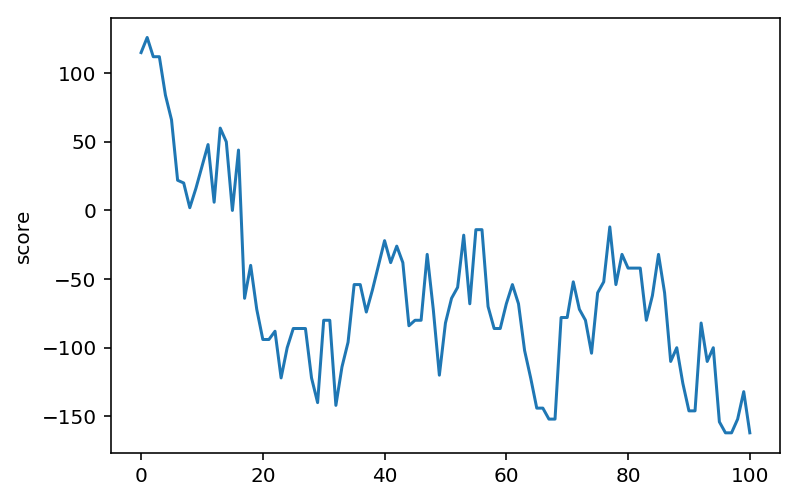

In [14]:
plt.plot(score_list)
plt.ylabel('score')
plt.show()

In [31]:
# temp = []
# temp.append(pop7)
# temp.append(pop2)
# pop_idx = [i for i in range(len(temp))]
# score = -1000; mid = []
# candidate = list(combinations(pop_idx, 2))
# scr = []; mid = []

# for i in range(len(candidate)):
#     individual1, individual2 = pop_list[candidate[i][0]], pop_list[candidate[i][1]]
#     ind_note1, ind_midi1 = pm.separate_song(individual1, 1920) 
#     score1, midi1 = get_fitness_score(ind_midi1, chord)
#     if score < score1 :
#         score = score1
#         mid = (midi1)
#     print(mid)

In [13]:
flatten_list(pop1)

[<message note_on channel=0 note=69 velocity=113 time=1440>,
 <message note_on channel=0 note=69 velocity=0 time=239>,
 <message note_on channel=0 note=71 velocity=113 time=1>,
 <message note_on channel=0 note=71 velocity=0 time=239>,
 <message note_on channel=0 note=72 velocity=113 time=1>,
 <message note_on channel=0 note=72 velocity=0 time=719>,
 <message note_on channel=0 note=71 velocity=113 time=1>,
 <message note_on channel=0 note=71 velocity=0 time=239>,
 <message note_on channel=0 note=76 velocity=100 time=1>,
 <message note_on channel=0 note=76 velocity=0 time=119>,
 <message note_on channel=0 note=72 velocity=113 time=1>,
 <message note_on channel=0 note=72 velocity=0 time=479>]